# Titanic Disaster - Kaggle Machine Learning Project

Author: Jean-Charl Pretorius

In [635]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

I will use lab 3 as a guide to perform an analysis on the Titanic Disaster dataset from Kaggle.

## Function definitions

In [636]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
     #TODO: Implement function body
    res = cross_validate(model, X=X, y=y, scoring=scoring, cv=cv, return_train_score=True)
    training_score = res['train_score'].mean()
    validation_score = res['test_score'].mean()
    
    return training_score, validation_score

In [637]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    
    print(grid_search.best_params_)
    print("training score= {:.3f}; validation score={:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
                                                                  grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [638]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
#     ['classifier', 'classifier__max_depth', 'classifier__max_features']
    if ('classifier' in params):
        params.remove('classifier')
    
    # remove the classifier__ prefix
    labels = [i.replace('classifier__', '') for i in params]
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=labels[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=labels[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [639]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(mat, 
                xticklabels=labels,  
                yticklabels=labels, 
                square=True, annot=True, cbar=False, 
                fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load the titanic data set
Titanic dataset from:
https://www.kaggle.com/competitions/titanic/data

In [640]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_copy = test.copy(deep=True)

## Inspect the data set

In [641]:
# Print the training column names
print('Train columns:', train.columns.tolist())

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [642]:
# View training dataframe
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [643]:
# Describe to get an understanding of the data
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [644]:
# training set info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [645]:
# testing set info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Visualize the data 

Now lets visualize the training data to get an idea of how age, sex, and passenger class relates to survival

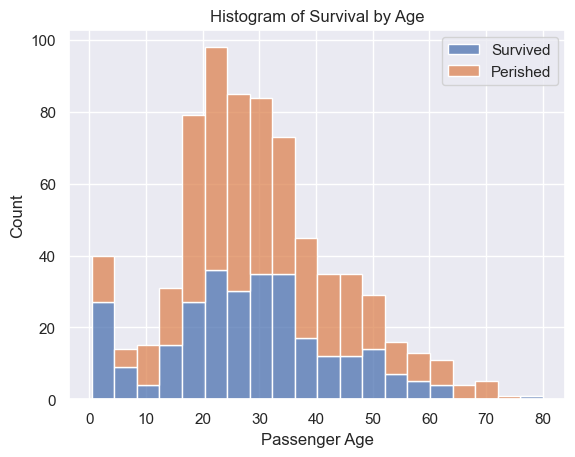

In [646]:
# histogram of survival and age
ax=sns.histplot(x='Age', hue='Survived', data=train, multiple='stack', palette=['C1', 'C0'], kde=False, bins=20, legend=False)

plt.title('Histogram of Survival by Age')
plt.xlabel("Passenger Age");
plt.legend(labels=['Survived', 'Perished']);


From the histogram we may observe that younger passengers were slightly more likely to survive

In [647]:
male_survivors = train.loc[train.Sex == 'male']["Survived"]
male_survival_rate = sum(male_survivors) / len(male_survivors)
print(f'{male_survival_rate*100:.2f} % of males survived')

18.89 % of males survived


In [648]:
female_survivors = train.loc[train.Sex == 'female']["Survived"]
female_survival_rate = sum(female_survivors) / len(female_survivors)
print(f'{female_survival_rate*100:.2f} % of females survived')

74.20 % of females survived


In [649]:
survivors = train["Survived"]
survival_rate = sum(survivors) / len(survivors)
print(f'{survival_rate*100:.2f} % of all passengers survived')

38.38 % of all passengers survived


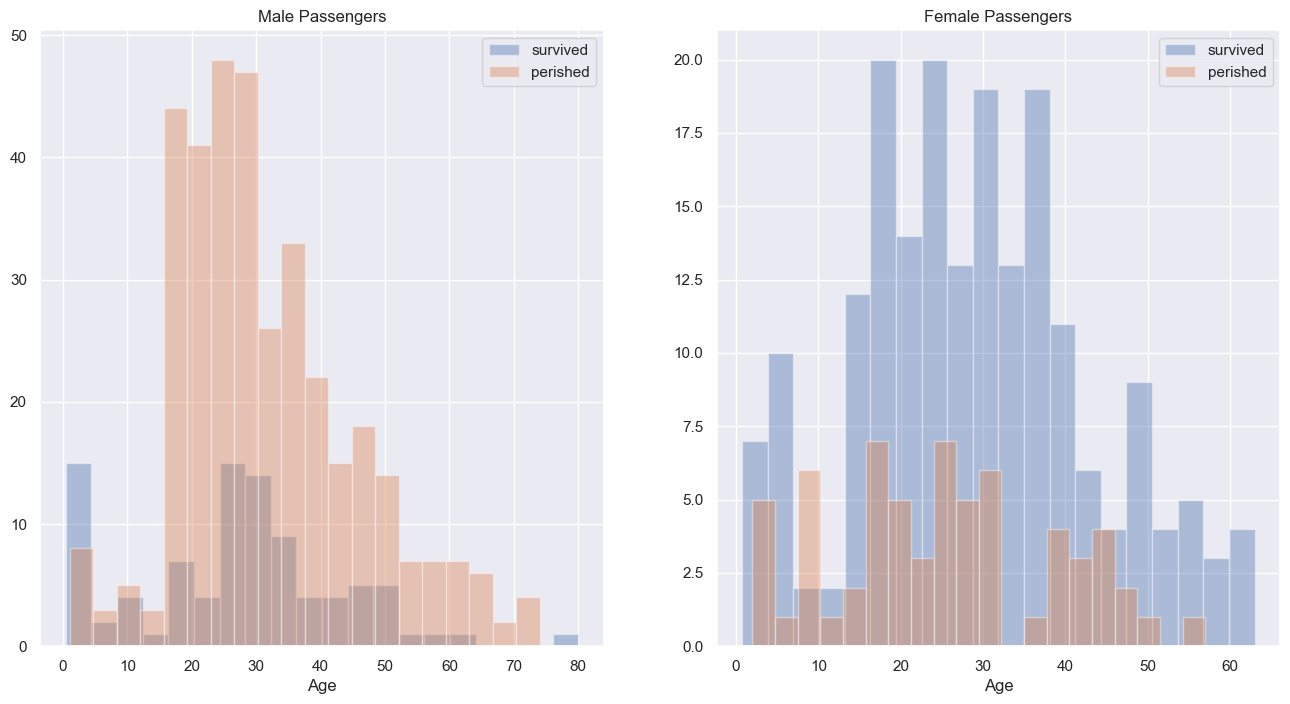

In [650]:
# hide depreciation warnings
import warnings
warnings.filterwarnings('ignore')

survived = 'survived'
perished = 'perished'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
males = train[train['Sex']=='male']
females = train[train['Sex']=='female']

# plot histogram for male passengers
ax = sns.distplot(males[males['Survived']==1].Age, bins=20, label=survived, ax=axes[0], kde=False)
ax = sns.distplot(males[males['Survived']==0].Age, bins=20, label=perished, ax=axes[0], kde=False)
ax.set_title('Male Passengers');
ax.legend()

# plot histogram for female passengers
ax = sns.distplot(females[females['Survived']==1].Age, bins=20, label=survived, ax=axes[1], kde=False)
ax = sns.distplot(females[females['Survived']==0].Age, bins=20, label=perished, ax=axes[1], kde=False)
ax.set_title('Female Passengers')
ax.legend();


Female passengers survived at a higher rate than male passengers

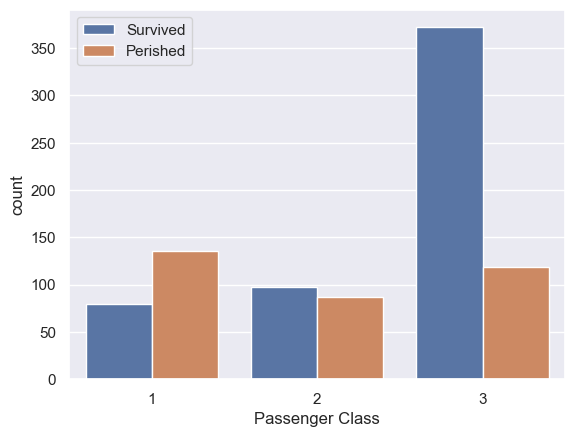

In [651]:
sns.countplot(x='Pclass', hue='Survived', data=train);
plt.xlabel("Passenger Class");
plt.legend(labels=['Survived', 'Perished']);


Passengers with a higher class ticket survived at a higher rate

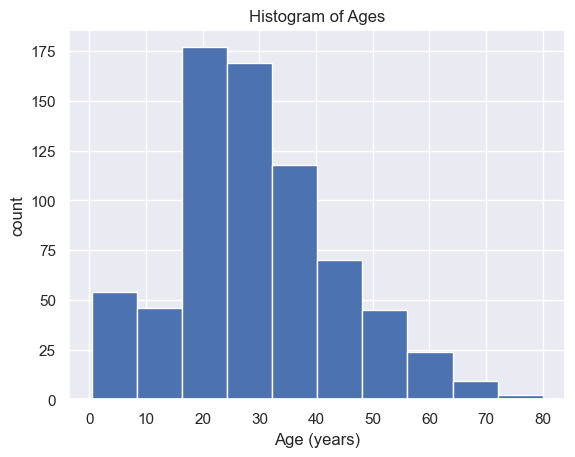

In [652]:
plt.hist(train['Age'])
plt.xlabel('Age (years)')
plt.ylabel('count')
plt.title('Histogram of Ages');

Age follows a roughly normal distribution

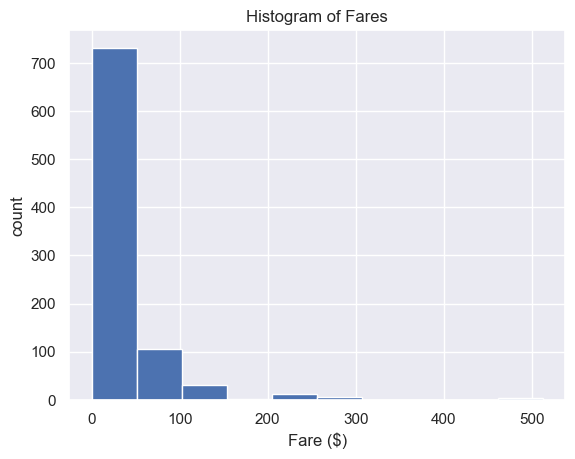

In [653]:
plt.hist(train['Fare'])
plt.xlabel('Fare ($)')
plt.ylabel('count')
plt.title('Histogram of Fares');

Passenger fares does not follow a normal distribution. We can use median instead of mean for the missing fare values.

### Data Imputation

In [654]:
# training set info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In the training set, we can see that there are many null values in the 'Age' and 'Cabin' columns, and 2 missing values in 'Embarked'. We also have a mix of numerical and categorical features

In [655]:
# Get the number of unique values in each column
unique = {}
for i, column in enumerate(train):
    unique[train.columns[i]] = train[column].nunique()

df_unique = pd.DataFrame(unique, index=[0])

    
print('Number of unique values in each column: ')
display(df_unique)

Number of unique values in each column: 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,891,2,3,891,2,88,7,7,681,248,147,3


The values for the Passengerid, Ticket, and Name columns are likely unimportant to the passenger survivorship, as they are nearly all unique. Cabin may be important and we could make the assumption that cabins with a similar letter are close together on the ship. With only 204 non-null values it may be better to just drop that column as well.

In [656]:
# Drop unimportant columns with unique values and many null values
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [657]:
# Handle the missing values

# drop NaN for 'Embarked' -> only 2 values
train.dropna(subset=['Embarked'], inplace=True)
train.reset_index(drop=True, inplace=True)


# replace NaN for 'Age' with mean 
train.Age.fillna(train.Age.mean(), inplace=True)
test.Age.fillna(test.Age.mean(), inplace=True)

# replace NaN for 'Fare' with median 
train.Fare.fillna(train.Fare.median(), inplace=True)
test.Fare.fillna(test.Fare.median(), inplace=True)



In [658]:
# train.Cabin
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Visualize the data again after data imputation

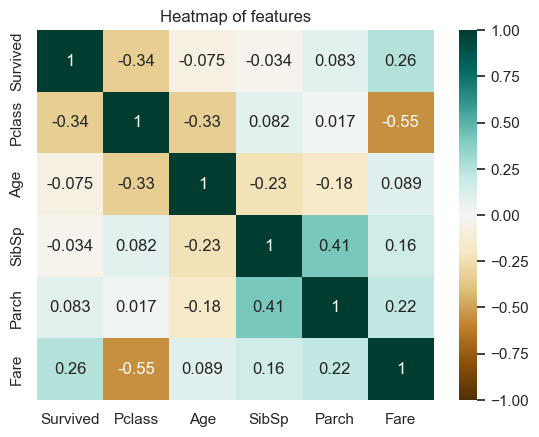

In [659]:
# Correlcation heatmap of features
corr = train.corr()
sns.heatmap(data=corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title("Heatmap of features");

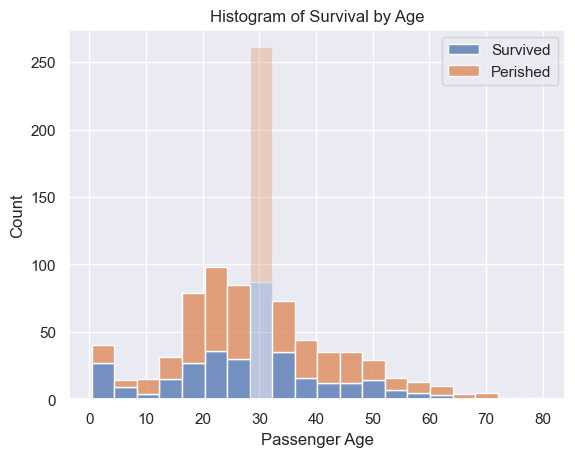

In [660]:
# histogram of survival and age
ax=sns.histplot(x='Age', hue='Survived', data=train, multiple='stack', palette=['C1', 'C0'], kde=False, bins=20, legend=False)

# recolor bin with missing values imputed by mean age of 29.7
ax.patches[7].set_facecolor('C0')
ax.patches[7].set_alpha(0.3)
ax.patches[27].set_facecolor('C1')
ax.patches[27].set_alpha(0.3)

plt.title('Histogram of Survival by Age')
plt.xlabel("Passenger Age");
plt.legend(labels=['Survived', 'Perished']);


## 2. Preprocessing

### Prepare Feature matrix and Target Vector

In [661]:
# separate the feature matrix and target vector
y = train['Survived']
X = train.drop(columns='Survived', axis=1)

In [662]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.000000,1,0,7.2500,S
1,1,female,38.000000,1,0,71.2833,C
2,3,female,26.000000,0,0,7.9250,S
3,1,female,35.000000,1,0,53.1000,S
4,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
884,2,male,27.000000,0,0,13.0000,S
885,1,female,19.000000,0,0,30.0000,S
886,3,female,29.642093,1,2,23.4500,S
887,1,male,26.000000,0,0,30.0000,C


In [663]:
# View the shape of the data
print("Shape of X: {}".format(X.shape))
print("Type of X: {}".format(type(X)))

print("\nShape of y: {}".format(y.shape))
print("Type of y: {}".format(type(y)))

Shape of X: (889, 7)
Type of X: <class 'pandas.core.frame.DataFrame'>

Shape of y: (889,)
Type of y: <class 'pandas.core.series.Series'>


## 3. Split the data into test and training sets


In [664]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.2)

In [665]:
# Inspect column names
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

### Encode the categorical features

Build a column transformer and use One-Hot encoding and Standard Scaler

In [666]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [667]:
# Separate column labels for categorical features
non_categorical = ['Age', 'SibSp', 'Parch', 'Fare']
categorical = ['Pclass', 'Sex', 'Embarked']


col_transformer = ColumnTransformer([
    ("scaling", StandardScaler(), non_categorical),
    ("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical)])


In [668]:
#Fit the column transformer
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [669]:
# Transform the data
X_train_preprocessed = col_transformer.transform(X_train)
X_test_preprocessed = col_transformer.transform(X_test)

Get the column names so that we can view the data as a dataframe

In [670]:
# one-hot encoded columns
onehot_col_names = col_transformer.named_transformers_['onehot'].get_feature_names_out()

In [671]:
col_names = np.concatenate((non_categorical, onehot_col_names))

In [672]:
# Convert the data back into DataFrames
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=col_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=col_names)

In [673]:
X_train_preprocessed_df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.190219,-0.469022,-0.463872,-0.370211,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.037013,0.470343,-0.463872,-0.077771,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.012174,-0.469022,-0.463872,0.493865,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.648263,-0.469022,-0.463872,-0.474506,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.012174,-0.469022,-0.463872,-0.077771,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## 4. Compare Models Using Cross Validation

Use cross validation to compare the performance of the following models:

`BernoulliNB()`

`LogisticRegression(max_iter=2000, random_state=55)`

`SVC()`

`RandomForestClassifier(random_state=55)`

`GradientBoostingClassifier(random_state=55)` 


In [674]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# scoring="f1"
# scoring='average_precision'
scoring='accuracy'
cv=7
seed=55

model_list = [BernoulliNB(), LogisticRegression(max_iter=2000, random_state=seed), SVC(), RandomForestClassifier(random_state=seed), GradientBoostingClassifier(random_state=seed)]
results = {}

print("Model comparison accuracy:")

for model in model_list:
    training_score, validation_score = get_classifier_cv_score(model, X_train_preprocessed_df, y_train, scoring=scoring, cv=cv)
    model_name = model.__class__.__name__
    results[model_name] = [training_score, validation_score]
    print("{0}:\n\tTraining:   {1:.3f}\n\tValidation: {2:.3f}".format(model_name, training_score, validation_score))
    


Model comparison accuracy:
BernoulliNB:
	Training:   0.776
	Validation: 0.779
LogisticRegression:
	Training:   0.806
	Validation: 0.796
SVC:
	Training:   0.831
	Validation: 0.819
RandomForestClassifier:
	Training:   0.986
	Validation: 0.785
GradientBoostingClassifier:
	Training:   0.911
	Validation: 0.804


The preliminary results before any tuning show that SVC is the best model with a validation score of 0.820. It appears that the descision tree models, especially random forest, might be overfitting

## 5. Hyperparameter tuning with GridSearchCV

### Logistic Regression GridSearch

In [675]:
# Create pipeline using the column transformer (one-hot encoder and standard scaler) 
# and the classifier model
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[('preprocessor', col_transformer),
                      ('classifier', LogisticRegression(max_iter=1000))])

In [676]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [677]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__C': [0.001,0.01, 0.1, 1.0, 10.0],
             'classifier__fit_intercept': [True, False]}
lr_grid_search = GridSearchCV(pipe, param_grid, cv=7, n_jobs=-1, return_train_score=True)

In [678]:
# Fit the logistic regression model
lr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaling',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'classifier__fit_intercept': [True, False]},
             return_train_score=True)

In [679]:
# Print grid search results
print_grid_search_result(lr_grid_search)

{'classifier__C': 0.1, 'classifier__fit_intercept': True}
training score= 0.809; validation score=0.802


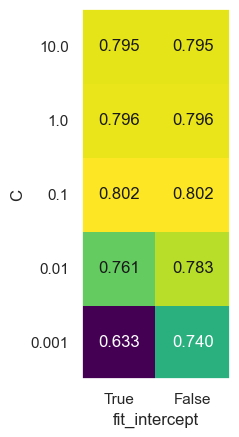

In [680]:
# Plot the grid search results
plot_grid_search_results(lr_grid_search)

The best parameters for LogisticRegression are:

- C = 1.0
- fit_intercept: False

These parameters gives us a validation score of 0.802

### Support Vector Classifier GridSearch

In [681]:
svc_param_grid = {'classifier': [SVC()], 
                  'classifier__C': [0.0001,0.001,0.1,1, 10, 100],
                  'classifier__gamma':[0.0001,0.001,0.1,1,10,50,100],
                  'classifier__kernel':['rbf'],
                  'classifier__degree' : [1,2,3,4]}

svc_grid_search = GridSearchCV(pipe, svc_param_grid, scoring='accuracy', cv=7, n_jobs=-1, return_train_score=True)

In [682]:
# Fit the model
svc_grid_search.fit(X_train, y_train);

In [683]:
# print the Suppor Vector Classifier grid search result
print_grid_search_result(svc_grid_search)

{'classifier': SVC(C=1, degree=1, gamma=0.1), 'classifier__C': 1, 'classifier__degree': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
training score= 0.826; validation score=0.820


The best parameters for Support Vector Classifier are: 
- C = 1
- Gamma = 0.1
- degree: 1
- kernel: 'rbf'

These parameters gives us a validation score of 0.820

### RandomForest GridSearch

In [684]:
rforest_param_grid = {'classifier': [RandomForestClassifier(random_state=43)],
                      'classifier__max_depth': [1, 3, 5, 7, 9], 
                      'classifier__max_features': [0.3, 0.5, 0.7, 0.9, 1.]}

rforest_grid_search = GridSearchCV(pipe, rforest_param_grid, cv=7, n_jobs=-1, scoring='accuracy', return_train_score=True)


In [685]:
# Fit the model
rforest_grid_search.fit(X_train, y_train);

In [686]:
# print the random forest grid search result
print_grid_search_result(rforest_grid_search)

{'classifier': RandomForestClassifier(max_depth=7, max_features=0.5, random_state=43), 'classifier__max_depth': 7, 'classifier__max_features': 0.5}
training score= 0.916; validation score=0.823


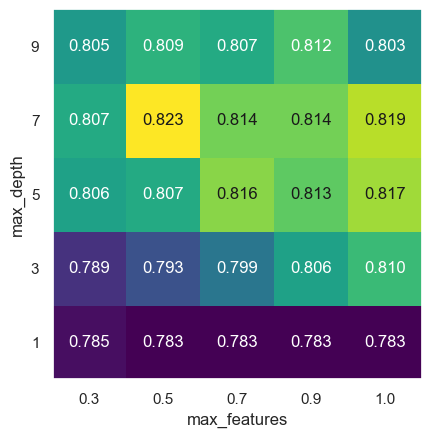

In [687]:
# Plot the random forest grid search results
plot_grid_search_results(rforest_grid_search)

The best parameters for Random Forest Classifier are: 
- max_features = 0.5
- max_depth=7

These parameters gives us a validation score of 0.823

### Gradient Boosting Classifier GridSearch

In [688]:
gb_param_grid = {'classifier': [GradientBoostingClassifier(random_state=56)], 
                      'classifier__n_estimators': [50, 100, 200, 400, 600], 
                      'classifier__max_depth': [1, 3, 5, 7, 9],
                      'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0]}

gb_grid_search = GridSearchCV(pipe, gb_param_grid, cv=7, n_jobs=-1, scoring='accuracy', return_train_score=True)

In [689]:
# Fit the model
gb_grid_search.fit(X_train, y_train);

In [690]:
# print the Gradient Boosting Classifier grid search result
print_grid_search_result(gb_grid_search)

{'classifier': GradientBoostingClassifier(learning_rate=0.01, max_depth=5, random_state=56), 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
training score= 0.885; validation score=0.827


The best parameters for Gradient Boosting Classifier are: 
- n_estimators = 100
- max_depth = 5
- learning_rate = 0.01

These parameters gives us a validation score of 0.827

Now we can set the learning rate and use just 2 parameters to visualize the scores and check if our max_depth and n_estimators parameter lists are within a reasonable range

In [691]:
# Run gridsearch with 2 hyperparameters and narrowed tuning range
gb_param_grid = {'classifier': [GradientBoostingClassifier(random_state=56, learning_rate=0.01)], 
                      'classifier__n_estimators': [50, 75, 100, 125, 150, 200], 
                      'classifier__max_depth': [3, 4, 5, 6, 7]}
gb_grid_search = GridSearchCV(pipe, gb_param_grid, cv=7, n_jobs=-1, scoring='accuracy', return_train_score=True)

In [692]:
# fit the model
gb_grid_search.fit(X_train, y_train);

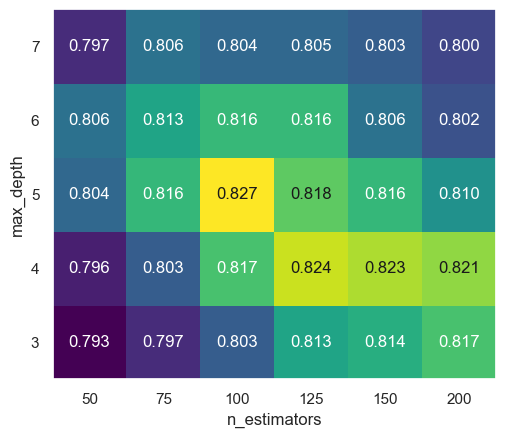

In [693]:
# plot the grid search results
plot_grid_search_results(gb_grid_search)

The best parameters are unchanged from the first gridSearch run

#### Grid Search Summary:

The best model we found with grid search is the gradient boosting classifier with a score of 0.827

## 6. Retrain the Best Model 

Retrain column transformer on the entire training set, then use it to transform both the training and test sets

In [694]:
# Retrain the column transformer 
col_transformer.fit(X)

ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [695]:
# Transform the data
X_preprocessed = col_transformer.transform(X)
test_preprocessed = col_transformer.transform(test)

In [696]:
# Convert the data back into DataFrames with correct column names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=col_names)
test_preprocessed_df = pd.DataFrame(test_preprocessed, columns=col_names)

In [697]:
# Display the DataFrame
X_preprocessed_df.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.589620,0.431350,-0.474326,-0.500240,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.644848,0.431350,-0.474326,0.788947,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.281003,-0.475199,-0.474326,-0.486650,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.413385,0.431350,-0.474326,0.422861,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.413385,-0.475199,-0.474326,-0.484133,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Retrain the Gradient Boosting Classifier with the best Parameters

In [698]:
# Retrain model
best_model_gb = GradientBoostingClassifier(random_state=56, learning_rate=0.01, max_depth=5, n_estimators=100)

In [699]:
# fit model to training data
best_model_gb.fit(X_preprocessed_df, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, random_state=56)

In [700]:
# Use the model to predict the test data
test_pred = best_model_gb.predict(test_preprocessed_df)

## 7. Evaluate using test data

### 7.1 Confusion matrix and classification report

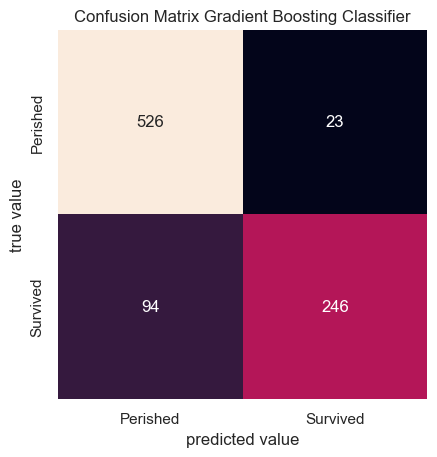

In [702]:

y_pred = best_model_gb.predict(X_preprocessed_df)
plot_confusion_matrix(y, y_pred, ['Perished', 'Survived'] , title="Confusion Matrix Gradient Boosting Classifier")

### 7.2 Classification report

In [703]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       549
           1       0.91      0.72      0.81       340

    accuracy                           0.87       889
   macro avg       0.88      0.84      0.85       889
weighted avg       0.87      0.87      0.86       889



### What are the precision, recall and accuracy for the positive class on the test set?

##### For the positive class ("Survived"):

Precision = 0.91

Recall = 0.72

Accuracy = 0.87

###  How many false negatives and false positives does the model produce on the test set?

False Negatives: 94

False Positives: 23

## 8. Kaggle submission

In [ ]:
# convert prediction to DataFrame
output = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_pred})
output

In [ ]:
# Save submission as csv for kaggle submission
submission = output.to_csv("submission_gb.csv", index=False)

## 9. Conclusion

The proposed topic of investigating the Titanic data set on Kaggle to predict if passengers died in the disaster was successful. The main steps outlined in the project proposal were implemented as specified.

Submitting these results achieved an accuracy of 0.78229 on Kaggle. At the time of this first submission, this was enough to place #2605 on the Kaggle leaderboard.

There were significantly more false negatives (94 passengers predicted to have perished but actually survived) than false positives (23 passengers predicted to have survived but actually perished), which resulted in a higher precision (0.91) than recall (0.72). 


The gradient boosting classifier outperformed all of the other models tested. After re-training the model on the entire training data set we achieved an accuracy of 0.87, which is quite a bit higher than the Kaggle score. This suggests that the model is overfitting the data. When we consider a relatively simple dataset like the Titanic disaster it is easy to overfit the data. In the context of this dataset, overfitting is not of much concern since there will never be any new data to apply this model to, because there is obviously not going to be any more 
RMS Titanic sinking in the future.






## 10. Reflection

I selected this problem to solve because I wanted to try doing a Kaggle competition and see how I can apply the models, preprocessing, and tuning techniques I learned the the course on my own. I was interested in getting a deeper understanding of such a notable historic disaster and the Titanic dataset was recommended as a good competition to start with for new Kaggle users.


There were no major deviations in my process of analyzing the data and applying the models from what I had planned in my project proposal. The Lab 3 assignment was a good template to base this project off of. I include the techiques of using a column transformer and a pipeline to my cross-validation and grid search sections so that I was properly handling the separation of which data was being used to fit the scalar and encoder. I did add the inclusion of BernoulliNB in the cross-validation section, and I unfortunately did not have time to extend the models investigated to include XGBoost.

The most difficult part of this project was the feature engineering and preprocessing step. I spent a lot of time figuring out what to do with the different categorical and non-categorical data, and I could have even spent much more time on it to improve my results. I learned a lot about proper preprocessing of data and how to separately scale or encode different columns in the same table. I gained a better understanding of how naively fitting a scaler on the data can 'leak' information from the test set into the parameter and model selection. Visualizing the data at the beginning was very useful and gave a good insite to which features could be important for the models. 

If I had more time I would have liked to see how the passenger's titles in their names could be used as features. Maybe a higher class title could be a predictor of survival, or I could have used the titles such as 'Master' or 'Miss' to signify that the passenger is younger when imputing missing age values.

I could have done something with the cabin names as well, such as grouping them by their section letter. I ultimately decided to drop that feature because of the large number of null values, but it may have been meaningful to keep the null values as their own class. 

Seeing how my submission ranked on Kaggle was motivating to try out other competitions in the future. 


